## read the pickel files for a given genome from the fasta and the illumina files:

### fasta:    dictionary of the format: fasta_dict[locus][kmer]=appearance
### illumina: dictionary of format illumina: illumina_dict[locus][kmer]=appearance


In [1]:
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from termcolor import colored
import matplotlib.pyplot as plt
import statsmodels.api as sm
from operator import itemgetter



In [2]:
# save pickle file:
def save_pickle(file, mydict):
    genomes = list(mydict.keys())
    for genome in genomes:
        with open('{}'.format(file), 'wb') as f:
            pickle.dump(mydict, f)


# read pickle file:
def read_pickle(path, file):
    start_time = datetime.now()
    with open('{}{}'.format(path, file), 'rb') as f:
        print('Read pickle file ...  {}'.format(file), end='')
        loaded_dict = pickle.load(f)
        print('     Duration: {}'.format(datetime.now()-start_time))
    return loaded_dict

# read the genome list form genomes.HPRC.txt
def read_genome_list(path, file_genomes):
    file_genomes = '{}{}'.format(path, genomes_file)
    genome_list = []
    genome_cnt = 0
    with open(file_genomes,'r') as f:
        while True:
            genome_cnt += 1
            if genome_cnt == -99+1:
                break
            genome = f.readline().rstrip()
            if genome == '':
                break
            genome_list.append(genome)    
    return genome_list


# read the orthoMap:
def read_orthoMap():
    path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
    file = '{}OrthoMap.v2.tsv'.format(path)
    
    df = pd.read_csv(file,sep='\t', header=None)
    df = df.replace('.', 'NaN')

    orthoMap = np.array(df)
    return orthoMap

          
def read_fasta_illumina(path, genome):
    illumina = dict()
    file = 'kmer_appearance_{}.pkl'.format(genome)
    file = 'illumina_dict_{}.pkl'.format(genome)
    illumina = read_pickle(path, file)

    fasta = dict()
    if len(illumina.keys()) > 0:
        file = 'fasta_dict_{}.pkl'.format(genome)
        fasta = read_pickle(path, file)

    return fasta, illumina


## Locus batch-r2

In [21]:
import pickle 
def locus_batch_r2(path, genomes):
    # create a nan array of the sice of orthoMap
    # two consecutive solumns per genome
    # the first column contains the number of the summed appearances in fasta, the second in Illumina
    # 
    orthoMap = read_orthoMap()
    batch_r2_freq = np.empty((orthoMap.shape[0], int(orthoMap.shape[1])))
    batch_r2_freq[:]=np.nan
    
    for g, genome in enumerate(genomes):
        print(colored('Genome: {}      ({}/{})'.format(genome, g, len(genomes)), 'green'))

        # read the fasta and illumina dictionaries:
        fasta, illumina = read_fasta_illumina(path, genome)
        
        # go through the illumina dictionary:
        if len(illumina.keys())>0:
            for i, locus in enumerate(fasta.keys()):
                # add the appearances of all kmers at this locus:
                fl = 0
                for kmer, freq in illumina[locus].items():
                    fl += freq
                # write fasta kmer appearance into matrix:
                batch_r2_freq[locus, g*2+1] = fl


            # go through the fasta dictionary:
            for i, locus in enumerate(fasta.keys()):
                # add the appearances of all kmers at this locus:
                fl = 0
                for kmer, freq in fasta[locus].items():
                    fl += freq
                # write fasta kmer appearance into atrix:
                batch_r2_freq[locus, g*2] = fl
    
    return batch_r2_freq

def locus_batch_r2_calc(batch_r2_freq):
    # create 2d array with length of all loci and 2 rows (statistic and pvalue):
    batch_r2_vector = np.empty((batch_r2_freq.shape[0], 3))
    batch_r2_vector[:] = np.nan
    
    for i in range(batch_r2_freq.shape[0]):
        # x-vector including nan are all even columns
        xx = batch_r2_freq[i,::2]
        # y-vector including nan are all odd columns
        yy = batch_r2_freq[i,1::2]
        
        # erase the nan values to get the x and y vectors
        x = xx[np.isfinite(xx) & np.isfinite(yy)]
        y = yy[np.isfinite(xx) & np.isfinite(yy)]
        
        # add a 0 to each vector
        x = np.append(x, 0)
        y = np.append(y, 0)

        # calculate the Pearson's R correlation:
        if (len(x)>2 and len(y)>2 and np.sum(x)>0 and np.sum(y)>0 and 
            all(x_test == x[0] for x_test in x)==False and all(y_test == y[0] for y_test in y)==False):
            # Pearson's R (that's the one for locus batch R2):
            PearsonsR = stats.pearsonr(x, y)
            batch_r2_vector[i,0] = np.square(PearsonsR[0])
            
            # statsmodels
            sm_results = sm.OLS(y, x).fit()
            batch_r2_vector[i,1] = sm_results.rsquared
            # calculate the R2 value using statsmodels with add_constant, 
            # i.e. we do not force the model to go through the origin:
            x_ = sm.add_constant(x)
            sm_results = sm.OLS(y, x_).fit()
            batch_r2_vector[i,2] = sm_results.rsquared
            
    
    return batch_r2_vector
    
    
    

In [22]:
# file that contains all genomes:
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
genomes_file = 'genomes.HPRC.txt'
genomes = read_genome_list(path, genomes_file)
#genomes = ['HG00438']

# create the batch-r2 matrix:
start_time_total = datetime.now()
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/files/'

start_time = datetime.now()
batch_r2_appearances = locus_batch_r2(path, genomes)
print('  batch_r2 appearance: {}\n'.format(datetime.now()-start_time))

start_time = datetime.now()
batch_r2_vector = locus_batch_r2_calc(batch_r2_appearances)
print('  batch_r2 matrix: {}'.format(datetime.now()-start_time))

print('\n  complete batch_r2 duration: {}'.format(datetime.now()-start_time_total))


# save the batch-r2 matrix:
print('Save the batch-r2 matrix   ...    ', end='')
start_time = datetime.now()
file = '{}locus_batch-r2.txt'.format(path)
np.savetxt(file, batch_r2_vector)
print('   Done    ({})'.format(datetime.now()-start_time))




Genome: HG002      (0/48)
Read pickle file ...  illumina_dict_HG002.pkl     Duration: 0:00:00.001475
Genome: HG00438      (1/48)
Read pickle file ...  illumina_dict_HG00438.pkl     Duration: 0:00:02.117245
Read pickle file ...  fasta_dict_HG00438.pkl     Duration: 0:00:04.042839
Genome: HG005      (2/48)
Read pickle file ...  illumina_dict_HG005.pkl     Duration: 0:00:00.001458
Genome: HG00621      (3/48)
Read pickle file ...  illumina_dict_HG00621.pkl     Duration: 0:00:01.856196
Read pickle file ...  fasta_dict_HG00621.pkl     Duration: 0:00:03.592259
Genome: HG00673      (4/48)
Read pickle file ...  illumina_dict_HG00673.pkl     Duration: 0:00:01.664104
Read pickle file ...  fasta_dict_HG00673.pkl     Duration: 0:00:03.708016
Genome: HG00733      (5/48)
Read pickle file ...  illumina_dict_HG00733.pkl     Duration: 0:00:01.535846
Read pickle file ...  fasta_dict_HG00733.pkl     Duration: 0:00:03.007449
Genome: HG00735      (6/48)
Read pickle file ...  illumina_dict_HG00735.pkl     Du

In [23]:
# read the batch-r2 matrix:
file = '{}locus_batch-r2.txt'.format(path)
batch_r2 = np.loadtxt(file)


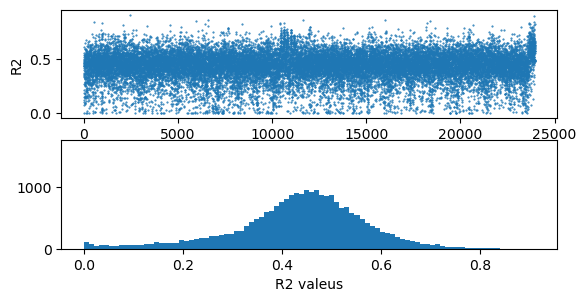

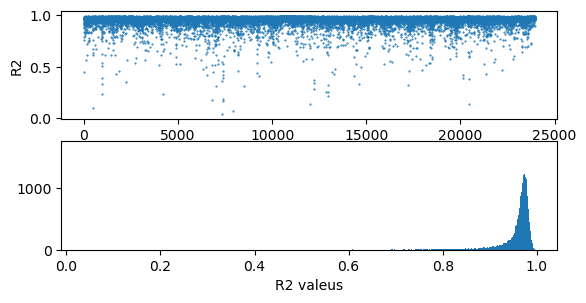

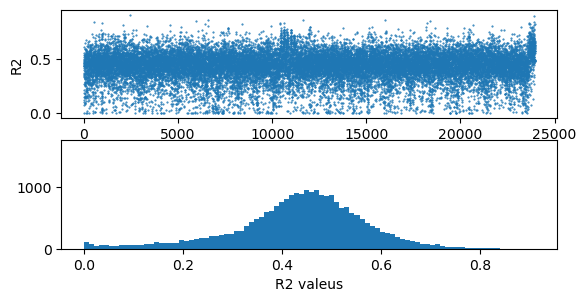

In [24]:
for i in range(3):
    if i == 0: 
        # plot the Pearson R values of R2 vs locus:
        yy = batch_r2[:,0]
    elif i == 1: 
        # plot the R2 value from statsmodels vs locus:
        yy = batch_r2[:,1]
    elif i == 2: 
        # plot the R2 value from statsmodels with add_constant vs locus:
        yy = batch_r2[:,2]

        
    plt.subplot(311)
    plt.plot(yy, '.', markersize=1)
    plt.xlabel('locus')
    plt.ylabel('R2')

    plt.subplot(312)
    plt.hist(yy, bins='auto')
    plt.ylim([0,1750])
    plt.xlabel('R2 valeus')

#    plt.subplot(313)
#    ys = np.sort(yy)
#    xs=np.arange(yy.size)
#    plt.plot(xs, ys, '.')
    
    plt.show()
    #plt.close()

In [ ]:
aa = np.empty((1,4))
aa[:]=np.nan
print(aa)
aa = np.append(aa, np.empty((1,4)), axis=0)
print(aa)
aa[-1,:]=2
print(aa)
aa[-1,:]=np.nan
print(aa)